In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import expm
from scipy.integrate import quad_vec
from pandas.tseries.offsets import DateOffset

# **Extract data - Peter Yields and granular Yields and all yields**

In [ ]:
# Load CSV, skipping first 10 rows and selecting only relevant columns
file_path = "feds200628.csv"  # Ensure correct file path
columns_to_use = ["Date", "BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]

df = pd.read_csv(file_path, skiprows=9, usecols=columns_to_use)

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Filter data for the period January 1995 - December 2024
df = df[(df["Date"] >= "1995-01-01") & (df["Date"] <= "2024-12-31")]


# Ensure that if the first trading day has missing data, move to the next available day
def get_first_valid_trading_day(group):
    return group.dropna(subset=["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]).iloc[0]

first_trading_day_params = df.groupby(df["Date"].dt.to_period("M")).apply(get_first_valid_trading_day).reset_index(drop=True)

# Define maturities (in years)
maturities = np.array([1, 2, 3, 5, 7, 10, 15, 20])

def nelson_siegel_svensson(beta0, beta1, beta2, beta3, tau1, tau2, maturities):
    """Calculate NSS yield curve for given maturities"""

    term = maturities  # Time to maturity
    factor1 = (1 - np.exp(-term / tau1)) / (term / tau1)
    factor2 = factor1 - np.exp(-term / tau1)
    factor3 = (1 - np.exp(-term / tau2)) / (term / tau2) - np.exp(-term / tau2)
    return beta0 + beta1 * factor1 + beta2 * factor2 + beta3 * factor3

# Nx360 matrix
monthly_yields = np.zeros(( len(maturities),len(first_trading_day_params)))

# Compute NSS yields for each month
for i, (_, row) in enumerate(first_trading_day_params.iterrows()):
    monthly_yields[:,i] = nelson_siegel_svensson(
        row["BETA0"], row["BETA1"], row["BETA2"], row["BETA3"],
        row["TAU1"], row["TAU2"], maturities
    )/100

# Define maturities (in years)
maturities_granular = np.array([1/12, 3/12, 6/12, 9/12,1, 3, 5, 20])

# Nx360 matrix
monthly_yields_granular = np.zeros(( len(maturities_granular),len(first_trading_day_params)))

# Compute NSS yields for each month
for i, (_, row) in enumerate(first_trading_day_params.iterrows()):
    monthly_yields_granular[:,i] = nelson_siegel_svensson(
        row["BETA0"], row["BETA1"], row["BETA2"], row["BETA3"],
        row["TAU1"], row["TAU2"], maturities_granular
    )/100

maturities_all = np.array([1/12,3/12,6/12,9/12,1,1.5, 2, 3, 5, 7, 10, 15, 20,30])

# Nx360 matrix
monthly_yields_all = np.zeros(( len(maturities_all),len(first_trading_day_params)))

# Compute NSS yields for each month
for i, (_, row) in enumerate(first_trading_day_params.iterrows()):
    monthly_yields_all[:,i] = nelson_siegel_svensson(
        row["BETA0"], row["BETA1"], row["BETA2"], row["BETA3"],
        row["TAU1"], row["TAU2"], maturities_all
    )/100

# **KF,LL,Maths, KF reconstructed Yield curve**

In [ ]:

def AFNS_kalman_filter_independent_PandQ(yields, maturities, kappa,theta,Lambda, sigma, X0,p0,measurement_std,LL):


    # Number of time steps (in months) and maturities
    n_timesteps = yields.shape[1] #360
    n_maturities = len(maturities) #8
    n_factors=Lambda.shape[0] #3

    # 1 month
    dt = 1/12

    # Create arrays for storing results
    # NB not matrix- 1D arrays (1xn_timeteps)
    r_estimates = np.zeros(n_timesteps)
    var_rt_estimates=np.zeros(n_timesteps)
    # 3xT matrix but each column is not a column vector
    # X[:,1] is 1D array of length 3
    X_estimates = np.zeros((n_factors,n_timesteps))
    # (3x3)xT matrix each cov matrix IS a numpy matrix!
    # P[:,:,1] is 3x3 numpy matrix
    p_estimates = np.zeros((n_factors,n_factors,n_timesteps))

    #X0 and p0 are matrices 3x1 and 3x3
    # Set initial values
    r_estimates[0] = X0[0, 0] + X0[1, 0]     # Initial short rate process
    var_rt_estimates[0] = p0[0, 0] + p0[1, 1] + 2*p0[0, 1]
    X_estimates[:,0] = X0.flatten()          # Initial state process
    p_estimates[:,:,0] = p0            # Initial uncertainty

    # B(τ) coefficient
    L=Lambda[1,1] #scalar
    # these are 8x1 matrices
    B_tau_one = -maturities/maturities
    B_tau_two = (-(1 - np.exp(-L * maturities)) / L)/maturities
    B_tau_three = (L*np.exp(-L * maturities) - (1 - np.exp(-L * maturities)) / L)/maturities

    B_tau_one = B_tau_one.reshape(-1, 1)
    B_tau_two = B_tau_two.reshape(-1, 1)
    B_tau_three = B_tau_three.reshape(-1, 1)
    # 8x3 matrix
    B_tau = np.concatenate([B_tau_one, B_tau_two, B_tau_three], axis=1)

    # A(tau)
    # scalars
    alpha1 = sigma[0, 0]**2
    alpha2 = sigma[1, 0]**2 + sigma[1, 1]**2
    alpha3 = sigma[2, 0]**2 + sigma[2, 1]**2 + sigma[2, 2]**2
    alpha4 = sigma[0, 0] * sigma[1, 0]
    alpha5 = sigma[0, 0] * sigma[2, 0]
    alpha6 = sigma[1, 0] * sigma[2, 0] + sigma[1, 1] * sigma[2, 1]

    # Exponentials 8x1 matrices
    e_L_tau = np.exp(-L * maturities)
    e_2L_tau = np.exp(-2 * L * maturities)

    # all these are 8x1 matrices
    term1 = (alpha1 * maturities**2) / 6

    term2 = alpha2 * ((1 / (2 * L**2)) - (1 / L**3) * (1 - e_L_tau) / maturities + (1 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    term3 = alpha3 * ((1 / (2 * L**2)) + (1 / L**2) * e_L_tau - (1 / (4 * L)) * maturities * e_2L_tau - (3 / (4 * L**2)) * e_2L_tau - (2 / L**3) * (1 - e_L_tau) / maturities + (5 / (8 * L**3)) * (1 - e_2L_tau) / maturities)

    term4 = alpha4 * ((1 / 2*L) * maturities + (1 / L**2) * e_L_tau - (1 / L**3) * (1 - e_L_tau) / maturities)

    term5 = alpha5 * ((3 / L**2) * e_L_tau + (1 / 2*L) * maturities + (1 / L) * maturities * e_L_tau - (3 / L**3) * (1 - e_L_tau) / maturities)

    term6 = alpha6 * ((1 / L**2) + (1 / L**2) * e_L_tau - (1 / (2 * L**2)) * e_2L_tau - (3 / L**3) * (1 - e_L_tau) / maturities + (3 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    #8x1 matrix
    A_tau = (term1 + term2 + term3 + term4 + term5 + term6)

    # 8x3 matrix
    H = -B_tau
    # 8x1 matrix
    h = -A_tau #/ maturities
    """
    # 3x3 matrix
    A=(np.identity(n_factors)-kappa)*dt
    # 3x1 matrix
    a=kappa@theta*dt

    # Extract diagonal elements of sigma (independent under P)
    sigma_diag = np.diag(np.diag(sigma))

    # Construct Q using only the diagonal elements
    Q = (sigma_diag @ sigma_diag.T) * dt
    """
    a = np.array((np.identity(3)-expm(-kappa * dt))@theta).reshape(3,1)
    A = np.array( expm(-kappa*dt)).reshape(3,3)

    def compute_Q(KP, Sigma, t):
        """
        Compute the Q covariance matrix for a multivariate OU process:
        Q = ∫₀ᵗ e^{-KP s} Σ Σᵀ e^{-KPᵀ s} ds
        """

        def integrand(s):
            matrix_exponential_lambda = expm(-KP * s)
            return matrix_exponential_lambda @ Sigma @ Sigma.T @ matrix_exponential_lambda.T

        # Integrate element-wise
        Q, _ = quad_vec(integrand, 0, t)
        return Q
    sigma_P = np.diag(np.diag(sigma))
    Q = compute_Q(kappa, sigma_P, dt)


    # 8x8 matrix
    R = measurement_std**2 * np.identity(n_maturities)

    # Kalman filter iterations
    for t in range(1, n_timesteps):

        #---------- 1. PREDICTION STEP ----------#
        # 3x1 matrix
        X_predicted = A @ X_estimates[:, t-1].reshape(3,1) + a

        # 3x3 matrix
        p_predicted = A @ p_estimates[:, :, t-1] @ A.T + Q

        #---------- 2. UPDATE STEP ----------#
        # 8x1 matrix
        yields_predicted = h + H @ X_predicted

        # 8x1 matrix
        y_bar = yields[:, t].reshape(n_maturities, 1) - yields_predicted

        # 8x8 matrix
        F = H @ p_predicted @ H.T + R

        # 3x8 matrix
        K = p_predicted @ H.T @ np.linalg.inv(F)

        # Update state estimate
        #remeber each column of X is 1D array of length 3
        X_estimates[:, t] = (X_predicted + K @ y_bar).flatten()
        r_estimates[t] = X_estimates[0, t] + X_estimates[1, t] #scalar + scaler = scalar

        # Update uncertainty estimate
        #3x3 matrix
        term1 = np.identity(n_factors) - K @ H
        #3x3 matrix
        term2 = K @ R @ K.T

        #3x3 matrix
        #remember each double layer of P is 3x3 matrix so no need to flatten
        p_estimates[:, :, t] = term1 @ p_predicted @ term1.T + term2

        #VAR(X+Y)=VAR(X) + VAR(Y) + 2*Cov(X,Y)
        var_rt_estimates[t] = p_estimates[0, 0, t] + p_estimates[1, 1, t] + 2*p_estimates[0, 1, t]

        LL += log_likelihood_step(y_bar, F)

    return r_estimates, var_rt_estimates, X_estimates,LL



def log_likelihood_step(y_bar, F):

    dy = y_bar.shape[0]
    sign, logdet = np.linalg.slogdet(F)
    if sign != 1:
        raise ValueError("Covariance matrix is not positive definite")
    inv_F = np.linalg.inv(F)
    term1 = -0.5 * dy * np.log(2 * np.pi)
    term2 = -0.5 * logdet
    term3 = -0.5 * y_bar.T @ inv_F @ y_bar
    return (term1 + term2 + term3).item()

def negative_log_likelihood(params, yields, maturities, X0, p0, LL0):
    #params is 1D array not matrix

    kappa = params[0:3]
    theta = params[3:6]
    lambda1 = params[6]
    sigma_flat = params[7:10]
    measurement_std = params[-1]

    Kappa=np.diag(kappa)

    Theta=theta.reshape(3,1)
    # Construct Lambda matrix from lambda1
    Lambda = np.array([
        [0.0,      0.0,      0.0],
        [0.0,  lambda1,   -lambda1],
        [0.0,      0.0,   lambda1]
    ])

    # Reconstruct sigma as lower-triangular
    Sigma = np.zeros((3, 3))
    np.fill_diagonal(Sigma, sigma_flat)
    #Sigma[np.tril_indices(3)] = sigma_flat

    # Kalman filter or log-likelihood calc
    _, _, _,neg_LL = AFNS_kalman_filter_independent_PandQ(
        yields, maturities,Kappa,Theta, Lambda, Sigma, X0, p0, measurement_std, LL0
    )

    return -neg_LL

def fisher_gilles_covariance(KP, Sigma):
  """
  Computes the steady-state covariance matrix Σ₀ using the Fisher & Gilles spectral decomposition method.
  """
  # Eigen-decomposition of KP
  d, V = np.linalg.eig(KP)       # d = eigenvalues, V = eigenvectors
  D = np.diag(d)
  V_inv = np.linalg.inv(V)

  S = V_inv @ Sigma @ Sigma.T @ V_inv.T

  # Compute L matrix with entries L_ij = S_ij / (d_i + d_j)
  n = D.shape[0]
  L = np.zeros((n, n))
  for i in range(n):
      for j in range(n):
          L[i, j] = S[i, j] / (d[i] + d[j])

  # Transform back to original basis
  Sigma_0 = V @ L @ V.T
  return Sigma_0


def AFNS_yield_curve(X_t, Lambda, sigma, maturities):
  #given a state process and the afns model params under Q we can reconstruct yields at various maturities and compare with historical data
    L=Lambda[1,1] #scalar
    # these are 8x1 matrices
    B_tau_one = -maturities/maturities
    B_tau_two = (-(1 - np.exp(-L * maturities)) / L)/maturities
    B_tau_three = (L*np.exp(-L * maturities) - (1 - np.exp(-L * maturities)) / L)/maturities

    B_tau_one = B_tau_one.reshape(-1, 1)
    B_tau_two = B_tau_two.reshape(-1, 1)
    B_tau_three = B_tau_three.reshape(-1, 1)

    # 8x3 matrix
    B_tau = np.concatenate([B_tau_one, B_tau_two, B_tau_three], axis=1)

    # A(tau)
    # scalars
    alpha1 = sigma[0, 0]**2
    alpha2 = sigma[1, 0]**2 + sigma[1, 1]**2
    alpha3 = sigma[2, 0]**2 + sigma[2, 1]**2 + sigma[2, 2]**2
    alpha4 = sigma[0, 0] * sigma[1, 0]
    alpha5 = sigma[0, 0] * sigma[2, 0]
    alpha6 = sigma[1, 0] * sigma[2, 0] + sigma[1, 1] * sigma[2, 1]

    # Exponentials 8x1 matrices
    e_L_tau = np.exp(-L * maturities)
    e_2L_tau = np.exp(-2 * L * maturities)

    # all these are 8x1 matrices
    term1 = (alpha1 * maturities**2) / 6

    term2 = alpha2 * ((1 / (2 * L**2)) - (1 / L**3) * (1 - e_L_tau) / maturities + (1 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    term3 = alpha3 * ((1 / (2 * L**2)) + (1 / L**2) * e_L_tau - (1 / (4 * L)) * maturities * e_2L_tau - (3 / (4 * L**2)) * e_2L_tau - (2 / L**3) * (1 - e_L_tau) / maturities + (5 / (8 * L**3)) * (1 - e_2L_tau) / maturities)

    term4 = alpha4 * ((1 / 2*L) * maturities + (1 / L**2) * e_L_tau - (1 / L**3) * (1 - e_L_tau) / maturities)

    term5 = alpha5 * ((3 / L**2) * e_L_tau + (1 / 2*L) * maturities + (1 / L) * maturities * e_L_tau - (3 / L**3) * (1 - e_L_tau) / maturities)

    term6 = alpha6 * ((1 / L**2) + (1 / L**2) * e_L_tau - (1 / (2 * L**2)) * e_2L_tau - (3 / L**3) * (1 - e_L_tau) / maturities + (3 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    #8x1 matrix
    A_tau = (term1 + term2 + term3 + term4 + term5 + term6)

    # 8x3 matrix
    H = -B_tau
    # 8x1 matrix
    h = -A_tau #/ maturities


    n_steps = X_t.shape[1]
    n_maturities = len(maturities)
    KF_yields = np.zeros((n_maturities,n_steps))

    for t in range(n_steps):
          KF_yields[:, t] = (h + H @ X_t[:,t].reshape(-1,1)).flatten()

    return KF_yields

# **forecasting excercise - Peter yields**

In [ ]:
def run_oos_forecast_test_expanding(yield_data_training,yield_data_forcasting, maturities,maturities_forecasted, start_idx, forecast_horizon, initial_guess):
    """
    Expanding window OOS test with warm-started parameter estimation.

    Supports multiple forecast horizons with minimal changes.

    Parameters:
    - forecast_horizon: int or list of ints (e.g., 6 or [1, 3, 6, 12])

    Returns:
    - results: dict of {h: {forecast_errors, predicted_yields, actual_yields}} + parameter_history
    """
    T = yield_data_training.shape[1]

    H = sorted(forecast_horizon)

    # Output structure
    results = {
        h: {
            "forecast_errors": [],
            "predicted_yields": [],
            "actual_yields": []
        }
        for h in H
    }
    parameter_history = []

    current_guess = initial_guess

    for t in range(start_idx, T - max(H)):
        print(f"Step {t - start_idx + 1}/{T - start_idx - max(H)}")

        # 1. Use all data up to t
        train_yields = yield_data_training[:, :t]

        # 2. Estimate AFNS parameters with warm start
        params, current_guess = estimate_afns_params(train_yields, maturities, current_guess)

        # 3. Run Kalman filter on training set
        X_filtered,LL = run_kalman_filter(train_yields, maturities, params, current_guess)
        print(LL)
        X_t = X_filtered[:, -1].reshape(3, 1)

        # 4. Forecast across multiple horizons
        for h in H:
            if t + h >= T:
                continue  # Skip if target is out of bounds

            X_forecast = forecast_state_h_steps_ahead(X_t, params, h)
            y_hat = AFNS_yield_curve(X_forecast, params["Lambda"], params["Sigma"], maturities_forecasted)[:, -1]
            y_true = yield_data_forcasting[:, t + h]

            rmse = np.sqrt(np.mean((y_true - y_hat)**2))

            results[h]["forecast_errors"].append(rmse)
            results[h]["predicted_yields"].append(y_hat)
            results[h]["actual_yields"].append(y_true)

        # 5. Save parameters (once per t)
        parameter_history.append(params)

    results["parameter_history"] = parameter_history
    return results

def estimate_afns_params(yields_train, maturities, initial_guess):
    """
    Run parameter estimation via likelihood maximization with warm start.

    Returns:
    - params_dict: dictionary with keys 'Kappa', 'Theta', 'Lambda', 'Sigma', 'measurement_std'
    - x_opt: flattened array of optimal parameters for next iteration
    """
    X0, p0 = construct_initial_state_and_covariance(initial_guess)
    LL0 = 0


    bounds = []
    bounds += [(1e-5, 10)] * 3        # kappa
    bounds += [(-0.1, 0.1)] * 3        # theta
    bounds += [(1e-2, 3)]           # lambda
    bounds += [(-1, 1)] * 3        # diag sigma
    bounds += [(1e-5, 0.01)]           # measurement noise


    # Minimize negative log likelihood
    result = minimize(
        negative_log_likelihood,
        initial_guess,
        args=(yields_train, maturities, X0, p0, LL0),
        bounds=bounds,
        method='L-BFGS-B',
    )

    x_opt = result.x

    # Unpack optimized params
    kappa_vals = x_opt[0:3]
    theta_vals = x_opt[3:6]
    lambda1 = x_opt[6]
    sigma_flat = x_opt[7:10]
    meas_std = x_opt[-1]

    Kappa = np.diag(kappa_vals)
    Theta = theta_vals.reshape(3, 1)
    Lambda = np.array([
        [0.0,      0.0,      0.0],
        [0.0,  lambda1,   -lambda1],
        [0.0,      0.0,   lambda1]
    ])
    Sigma = np.zeros((3, 3))
    np.fill_diagonal(Sigma, sigma_flat)

    params_dict = {
        "Kappa": Kappa,
        "Theta": Theta,
        "Lambda": Lambda,
        "Sigma": Sigma,
        "measurement_std": meas_std
    }

    return params_dict, x_opt

def forecast_state_h_steps_ahead(X_t, params, h):
    """
    Forecast X_{t+h} from X_t using closed-form OU expectation.

    Parameters:
    - X_t: np.ndarray, shape (3, 1), state at time t
    - params: dict containing 'Kappa' and 'Theta'
    - h: int, forecast horizon in months

    Returns:
    - X_forecast: np.ndarray, shape (3, 1), forecasted state at t+h
    """
    dt = 1 / 12  # monthly step
    Kappa = params["Kappa"]
    Theta = params["Theta"]

    exp_term = expm(-Kappa * h * dt)
    X_forecast = (np.identity(3) - exp_term) @ Theta + exp_term @ X_t

    return X_forecast


def construct_initial_state_and_covariance(initial_guess):
    """
    Given a flat parameter vector, construct X0 and P0 for Kalman filter.

    Parameters:
    - initial_guess: array-like of shape (11,)
      Format: [kappa1, kappa2, kappa3, theta1, theta2, theta3, lambda1, sigma1, sigma2, sigma3, measurement_std]

    Returns:
    - X0: np.ndarray of shape (3,1), initial state
    - P0: np.ndarray of shape (3,3), steady-state covariance matrix via Fisher-Gilles
    """
    initial_kappa = initial_guess[0:3]
    initial_theta = initial_guess[3:6]
    initial_sigma_diag = initial_guess[7:10]

    # Diagonal Kappa matrix (OU mean reversion speeds)
    Kappa = np.diag(initial_kappa)

    # Initial state (set to long-run mean)
    X0 = np.array(initial_theta).reshape(3, 1)

    # Volatility matrix (lower triangular, only diagonal entries used)
    Sigma = np.zeros((3, 3))
    np.fill_diagonal(Sigma, initial_sigma_diag)

    # Steady-state covariance using Fisher-Gilles method
    P0 = fisher_gilles_covariance(Kappa, Sigma)

    return X0, P0

def run_kalman_filter(train_yields, maturities, params, current_guess):
    X0, p0 = construct_initial_state_and_covariance(current_guess)
    _, _, X_filtered, LL = AFNS_kalman_filter_independent_PandQ(
        train_yields,
        maturities,
        params["Kappa"],
        params["Theta"],
        params["Lambda"],
        params["Sigma"],
        X0,
        p0,
        params["measurement_std"],
        LL=0
    )
    return X_filtered,LL



In [ ]:
maturities = np.array([1, 2, 3, 5, 7, 10, 15, 20]).reshape(8,1)
forecast_maturities=np.array([1,5,20]).reshape(3,1)
start=180
results = run_oos_forecast_test_expanding(
yield_data_training=monthly_yields,
    yield_data_forcasting=monthly_yields[[0, 3, 7], :],  # only 1Y, 5Y, 10Y rows
    maturities=maturities,
    maturities_forecasted=forecast_maturities,
    start_idx=start,
    forecast_horizon=[3,6,12],
    initial_guess = np.array([
    0.32915202, 0.17375438, 0.04368877,   # kappa
    0.05155623, 0.0001, 0.0081955,        # theta
    0.27407706,                           # lambda
    0.01266283, 0.01744135, 0.01819897,   # sigma diag
    0.000885                              # measurement noise
])
)


Step 1/168
Step 2/168
Step 3/168
Step 4/168
Step 5/168
Step 6/168
Step 7/168
Step 8/168
Step 9/168
Step 10/168
Step 11/168
Step 12/168
Step 13/168
Step 14/168
Step 15/168
Step 16/168
Step 17/168
Step 18/168
Step 19/168
Step 20/168
Step 21/168
Step 22/168
Step 23/168
Step 24/168
Step 25/168
Step 26/168
Step 27/168
Step 28/168
Step 29/168
Step 30/168
Step 31/168
Step 32/168
Step 33/168
Step 34/168
Step 35/168
Step 36/168
Step 37/168
Step 38/168
Step 39/168
Step 40/168
Step 41/168
Step 42/168
Step 43/168
Step 44/168
Step 45/168
Step 46/168
Step 47/168
Step 48/168
Step 49/168
Step 50/168
Step 51/168
Step 52/168
Step 53/168
Step 54/168
Step 55/168
Step 56/168
Step 57/168
Step 58/168
Step 59/168
Step 60/168
Step 61/168
Step 62/168
Step 63/168
Step 64/168
Step 65/168
Step 66/168
Step 67/168
Step 68/168
Step 69/168
Step 70/168
Step 71/168
Step 72/168
Step 73/168
Step 74/168
Step 75/168
Step 76/168
Step 77/168
Step 78/168
Step 79/168
Step 80/168
Step 81/168
Step 82/168
Step 83/168
Step 84/168
S

# **table and plotting code**

In [ ]:
def compute_rmse_tables_by_maturity(results, maturities):
    """
    Compute RMSE tables by maturity for each forecast horizon.

    Parameters:
    - results: dict from run_oos_forecast_test_expanding
    - maturities: list or array of maturities

    Returns:
    - rmse_tables: dict of {h: RMSE DataFrame}
    """
    maturities = np.array(maturities).flatten()
    rmse_tables = {}

    for h in sorted([k for k in results if isinstance(k, int)]):
        pred = np.array(results[h]["predicted_yields"])
        actual = np.array(results[h]["actual_yields"])

        squared_errors = (actual - pred) ** 2
        rmse_bp = np.sqrt(np.mean(squared_errors, axis=0)) * 100

        rmse_df = pd.DataFrame({
            "Maturity (Years)": maturities,
            "RMSE (bps)": rmse_bp.round(2)
        })

        print(f"\nForecast Horizon: {h} months")
        print(rmse_df.to_string(index=False))
        rmse_tables[h] = rmse_df

    return rmse_tables

def plot_forecast_errors_by_maturity(results, maturities, start_date, freq="MS"):
    """
    Plot absolute forecast errors over time for each maturity and forecast horizon.

    Parameters:
    - results: dict from run_oos_forecast_test_expanding (multi-horizon compatible)
    - maturities: list or array of maturities
    - start_date: datetime of the first forecast
    - freq: str, frequency of data ("MS" = month start)
    """
    maturities = np.array(maturities).flatten()

    for h in sorted([k for k in results if isinstance(k, int)]):
        pred = np.array(results[h]["predicted_yields"])
        actual = np.array(results[h]["actual_yields"])

        abs_errors = np.abs(actual - pred)
        time_index = pd.date_range(start=start_date, periods=abs_errors.shape[0], freq=freq)

        plt.figure(figsize=(12, 6))
        for i, m in enumerate(maturities):
            plt.plot(time_index, abs_errors[:, i], label=f"{m}Y")

        plt.title(f"Absolute Forecast Errors Over Time (h = {h} months)")
        plt.xlabel("Date")
        plt.ylabel("Absolute Error (%)")
        plt.legend(title="Maturity")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



def plot_afns_parameter_evolution(results, start_date, freq="MS"):
    """
    Plot the time series of each AFNS parameter group (kappa, theta, sigma) over forecast steps.

    Parameters:
    - results: dict from run_oos_forecast_test_expanding
    - start_date: datetime or string for first forecast date
    - freq: string frequency code (default "MS" for month-start)
    """
    param_hist = results["parameter_history"]
    time_index = pd.date_range(start=start_date, periods=len(param_hist), freq=freq)

    # Extract parameter vectors
    kappas = np.array([np.diag(p["Kappa"]) for p in param_hist])
    thetas = np.array([p["Theta"].flatten() for p in param_hist])
    sigmas = np.array([np.diag(p["Sigma"]) for p in param_hist])
    lambdas = np.array([p["Lambda"][1, 1] for p in param_hist])
    noise = np.array([p["measurement_std"] for p in param_hist])

    # Plot Kappas
    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.plot(time_index, kappas[:, i], label=f"Kappa {i+1}")
    plt.title("Kappa Parameters Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Thetas
    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.plot(time_index, thetas[:, i], label=f"Theta {i+1}")
    plt.title("Theta Parameters Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Sigmas
    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.plot(time_index, sigmas[:, i], label=f"Sigma {i+1}")
    plt.title("Sigma Parameters Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Lambda and measurement noise (optional)
    plt.figure(figsize=(10, 4))
    plt.plot(time_index, lambdas, label="Lambda", color='purple')
    plt.title("Lambda Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

       # Plot Lambda and measurement noise (optional)
    plt.figure(figsize=(10, 4))
    plt.plot(time_index, noise, label="Measurement Std", color='gray')
    plt.title("Measurement Noise Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# **analyse results**


Forecast Horizon: 3 months
 Maturity (Years)  RMSE (bps)
                1        0.61
                5        0.62
               20        0.58

Forecast Horizon: 6 months
 Maturity (Years)  RMSE (bps)
                1        1.00
                5        0.94
               20        0.82

Forecast Horizon: 12 months
 Maturity (Years)  RMSE (bps)
                1        1.67
                5        1.45
               20        1.16


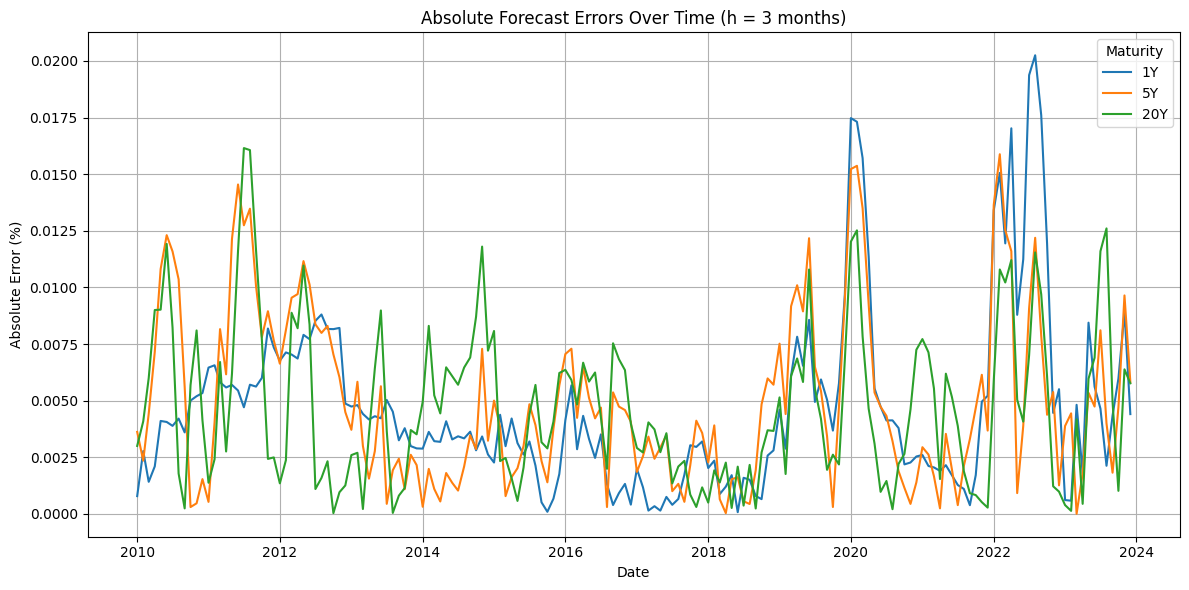

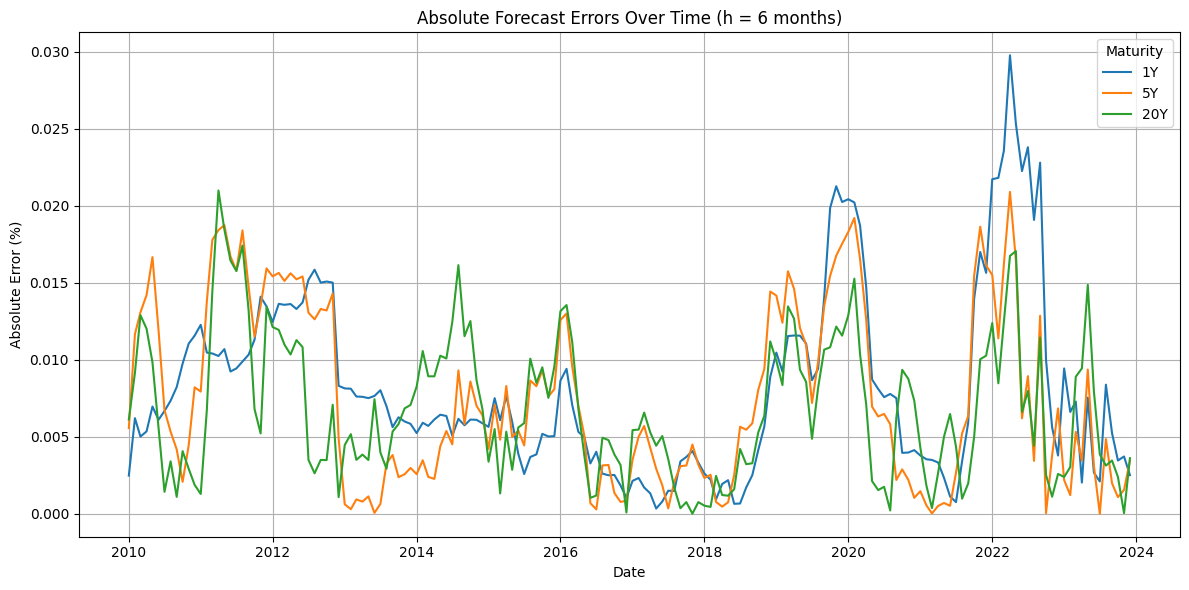

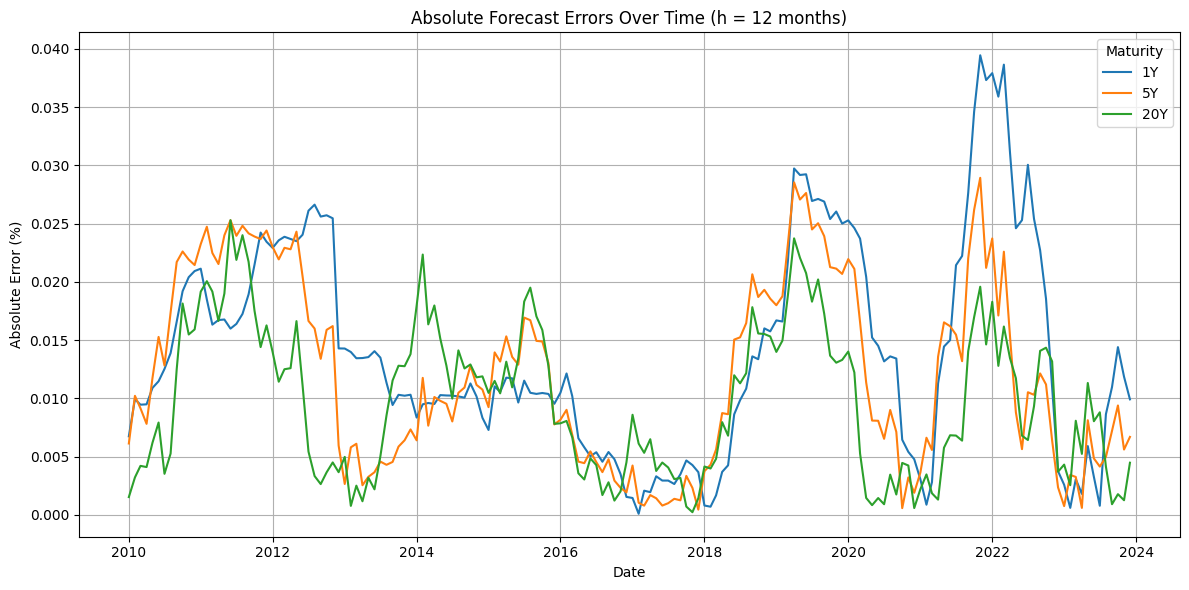

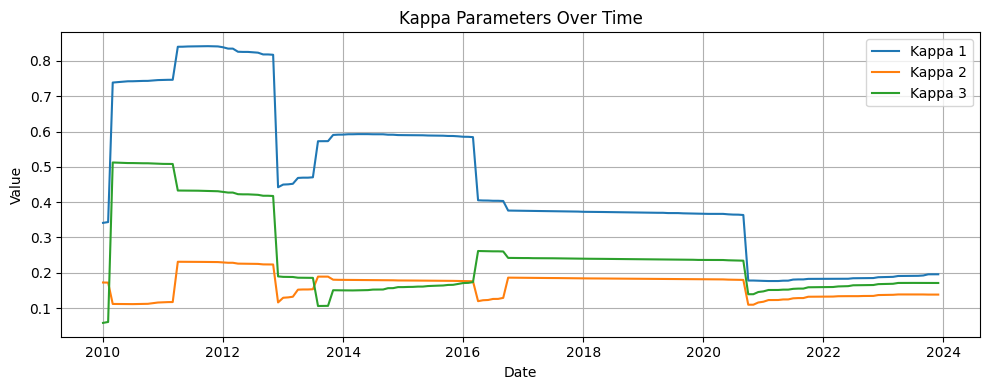

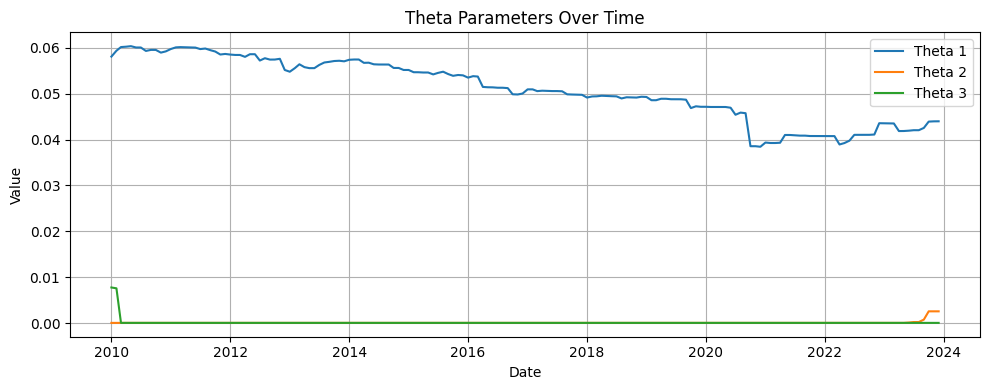

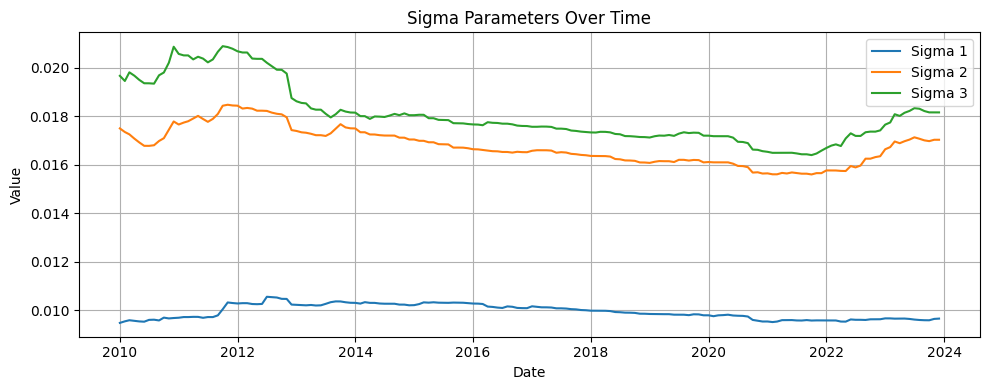

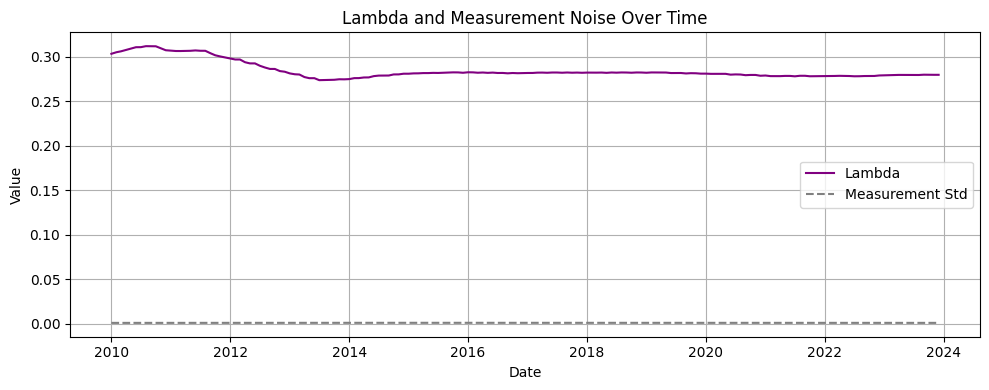

In [ ]:
# Align start date with forecast starting index
aligned_start_date = pd.to_datetime("1995-01-01") + DateOffset(months=start)

# Compute RMSE tables
rmse_tables = compute_rmse_tables_by_maturity(results, forecast_maturities)

# Plot errors
plot_forecast_errors_by_maturity(results, forecast_maturities, start_date=aligned_start_date)
plot_afns_parameter_evolution(results, start_date=aligned_start_date)

# **Granular yields forecasting excercise**

In [ ]:
maturities_granular = np.array([1/12, 3/12, 6/12, 9/12,1, 3, 5, 20]).reshape(8,1)
forecast_maturities_granular=np.array([1,5,20]).reshape(3,1)
start=180
results_granular = run_oos_forecast_test_expanding(
    yield_data_training=monthly_yields_granular,
    yield_data_forcasting=monthly_yields_granular[[4, 6, 7], :],  # only 1Y, 5Y, 10Y rows
    maturities=maturities_granular,
    maturities_forecasted=forecast_maturities_granular,
    start_idx=start,
    forecast_horizon=[3,6,12],
    initial_guess = np.array([
    0.32915202, 0.17375438, 0.04368877,   # kappa
    0.05155623, 0.0001, 0.0081955,        # theta
    0.27407706,                           # lambda
    0.01266283, 0.01744135, 0.01819897,   # sigma diag
    0.000885                              # measurement noise
])
)


Step 1/168
Step 2/168
Step 3/168
Step 4/168
Step 5/168
Step 6/168
Step 7/168
Step 8/168
Step 9/168
Step 10/168
Step 11/168
Step 12/168
Step 13/168
Step 14/168
Step 15/168
Step 16/168
Step 17/168
Step 18/168
Step 19/168
Step 20/168
Step 21/168
Step 22/168
Step 23/168
Step 24/168
Step 25/168
Step 26/168
Step 27/168
Step 28/168
Step 29/168
Step 30/168
Step 31/168
Step 32/168
Step 33/168
Step 34/168
Step 35/168
Step 36/168
Step 37/168
Step 38/168
Step 39/168
Step 40/168
Step 41/168
Step 42/168
Step 43/168
Step 44/168
Step 45/168
Step 46/168
Step 47/168
Step 48/168
Step 49/168
Step 50/168
Step 51/168
Step 52/168
Step 53/168
Step 54/168
Step 55/168
Step 56/168
Step 57/168
Step 58/168
Step 59/168
Step 60/168
Step 61/168
Step 62/168
Step 63/168
Step 64/168
Step 65/168
Step 66/168
Step 67/168
Step 68/168
Step 69/168
Step 70/168
Step 71/168
Step 72/168
Step 73/168
Step 74/168
Step 75/168
Step 76/168
Step 77/168
Step 78/168
Step 79/168
Step 80/168
Step 81/168
Step 82/168
Step 83/168
Step 84/168
S

# **analyse results**


Forecast Horizon: 3 months
 Maturity (Years)  RMSE (bps)
                1        0.53
                5        0.59
               20        0.54

Forecast Horizon: 6 months
 Maturity (Years)  RMSE (bps)
                1        0.82
                5        0.79
               20        0.71

Forecast Horizon: 12 months
 Maturity (Years)  RMSE (bps)
                1        1.34
                5        1.13
               20        0.94


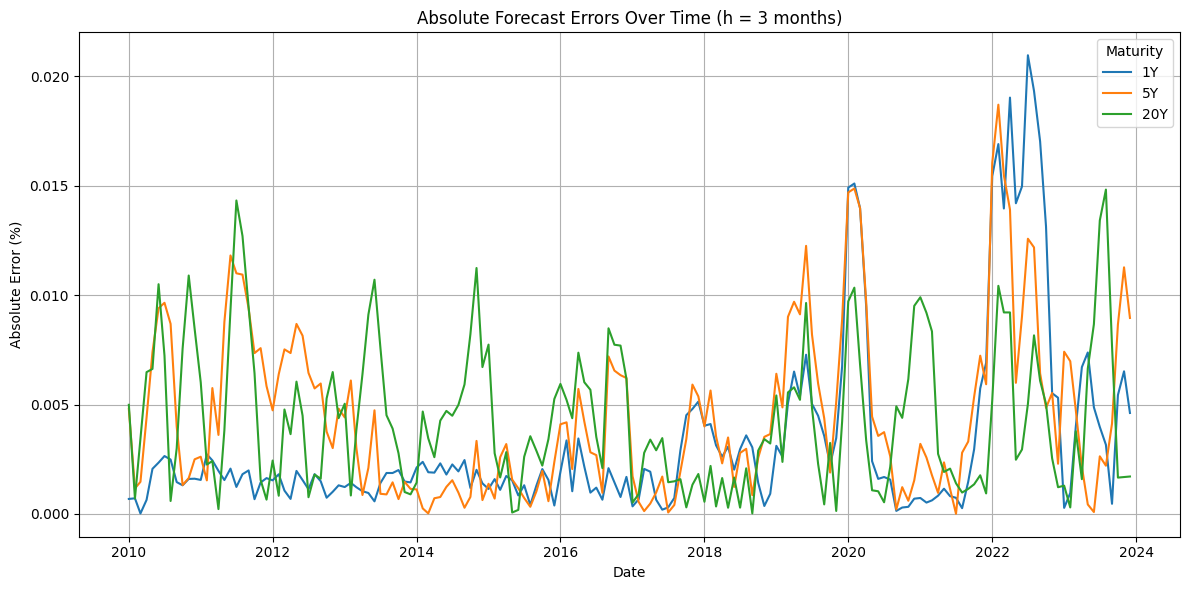

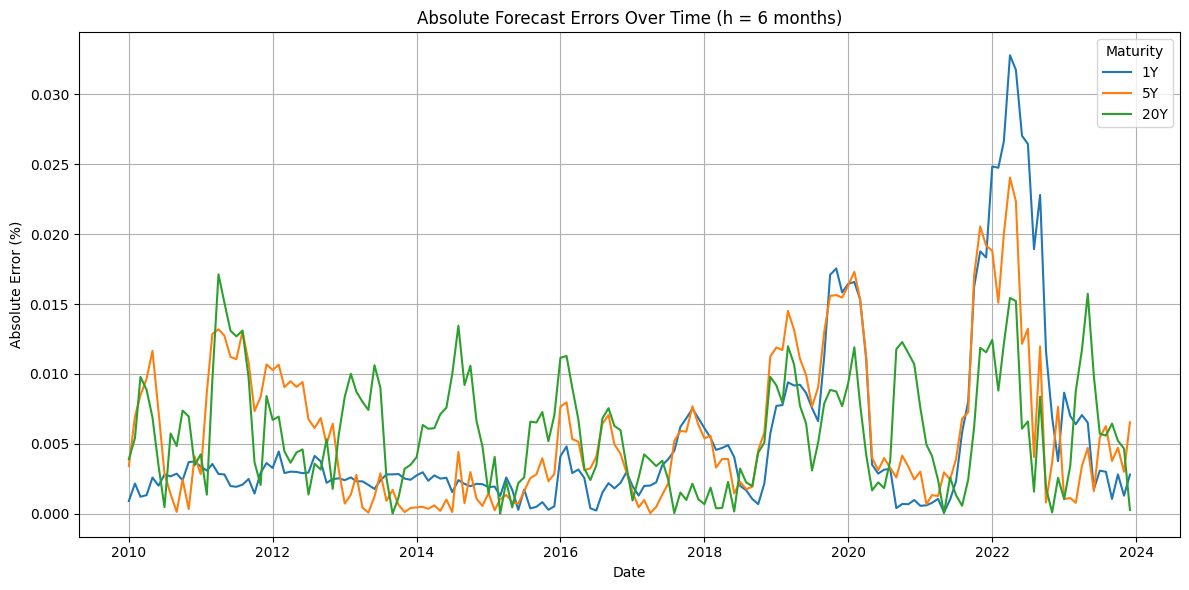

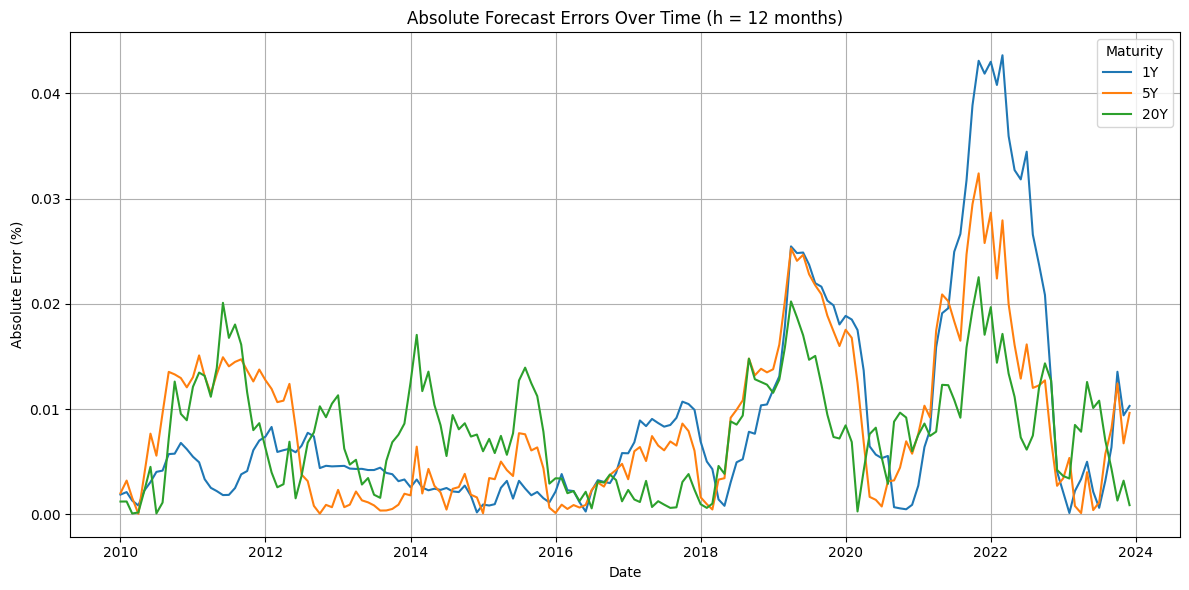

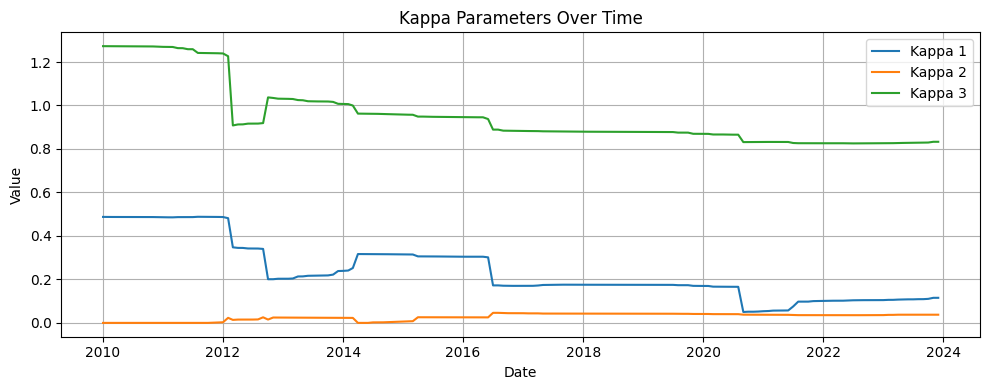

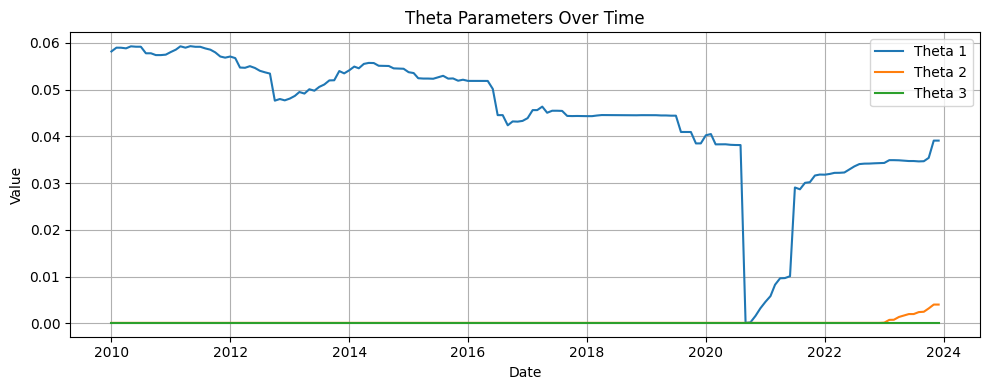

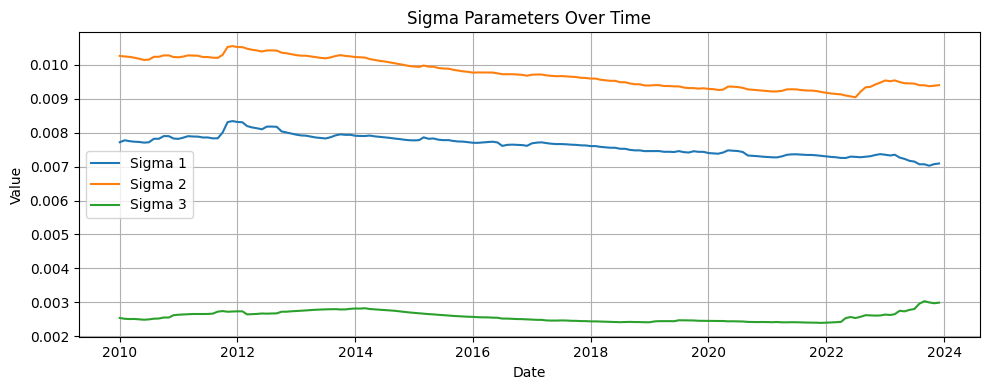

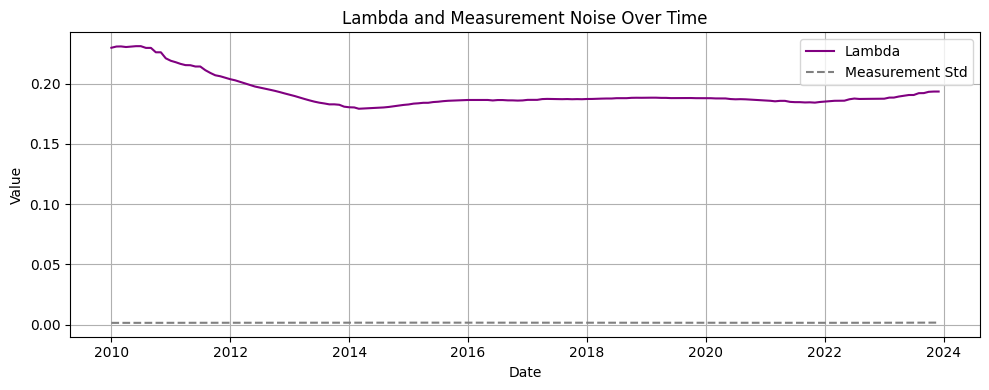

In [ ]:
# Align start date with forecast starting index
aligned_start_date = pd.to_datetime("1995-01-01") + DateOffset(months=start)

# Compute RMSE tables
rmse_tables = compute_rmse_tables_by_maturity(results_granular, forecast_maturities_granular)

# Plot errors
plot_forecast_errors_by_maturity(results_granular, forecast_maturities_granular, start_date=aligned_start_date)
plot_afns_parameter_evolution(results_granular, start_date=aligned_start_date)

# **all yields forecast**

In [ ]:
maturities_all = np.array([1/12,3/12,6/12,9/12,1,1.5, 2, 3, 5, 7, 10, 15, 20,30]).reshape(-1,1)
forecast_maturities_all=np.array([1,5,20]).reshape(3,1)
start=180
results_all = run_oos_forecast_test_expanding(
    yield_data_training=monthly_yields_all,
    yield_data_forcasting=monthly_yields_all[[4, 8, 10], :],  # only 1Y, 5Y, 10Y rows
    maturities=maturities_all,
    maturities_forecasted=forecast_maturities_all,
    start_idx=start,
    forecast_horizon=[3,6,12],
    initial_guess = np.array([
    0.07, 0.08, 0.3,   # kappa
    0.04, -0.02, 0,        # theta
    0.21,                           # lambda
    -0.004, 0.008, 0.003,   # sigma diag
    0.002                              # measurement noise
])
)

Step 1/168
11814.916770303393
Step 2/168
11879.840030456662
Step 3/168
11948.64113869453
Step 4/168
12015.796451735645
Step 5/168
12085.02786437651
Step 6/168
12154.946575950193
Step 7/168
12218.769425978728
Step 8/168
12280.058695615395
Step 9/168
12342.014815079236
Step 10/168
12400.374675706362
Step 11/168
12456.25251470109
Step 12/168
12500.697016208262
Step 13/168
12558.453212828961
Step 14/168
12621.44821487965
Step 15/168
12683.451106172692
Step 16/168
12751.502809167843
Step 17/168
12822.05759734846
Step 18/168
12891.274187588186
Step 19/168
12950.45160549769
Step 20/168
13014.228304295595
Step 21/168
13060.246951686786
Step 22/168
13097.717289564129
Step 23/168
13141.04386267114
Step 24/168
13202.038351186122
Step 25/168
13264.024363684108
Step 26/168
13325.5499087873
Step 27/168
13379.888454622902
Step 28/168
13439.407595671411
Step 29/168
13499.284798570121
Step 30/168
13555.38330112071
Step 31/168
13603.075261824117
Step 32/168
13662.443659502225
Step 33/168
13721.538595574


Forecast Horizon: 3 months
 Maturity (Years)  RMSE (bps)
                1        0.53
                5        0.59
               20        0.86

Forecast Horizon: 6 months
 Maturity (Years)  RMSE (bps)
                1        0.83
                5        0.77
               20        1.01

Forecast Horizon: 12 months
 Maturity (Years)  RMSE (bps)
                1        1.36
                5        1.10
               20        1.23


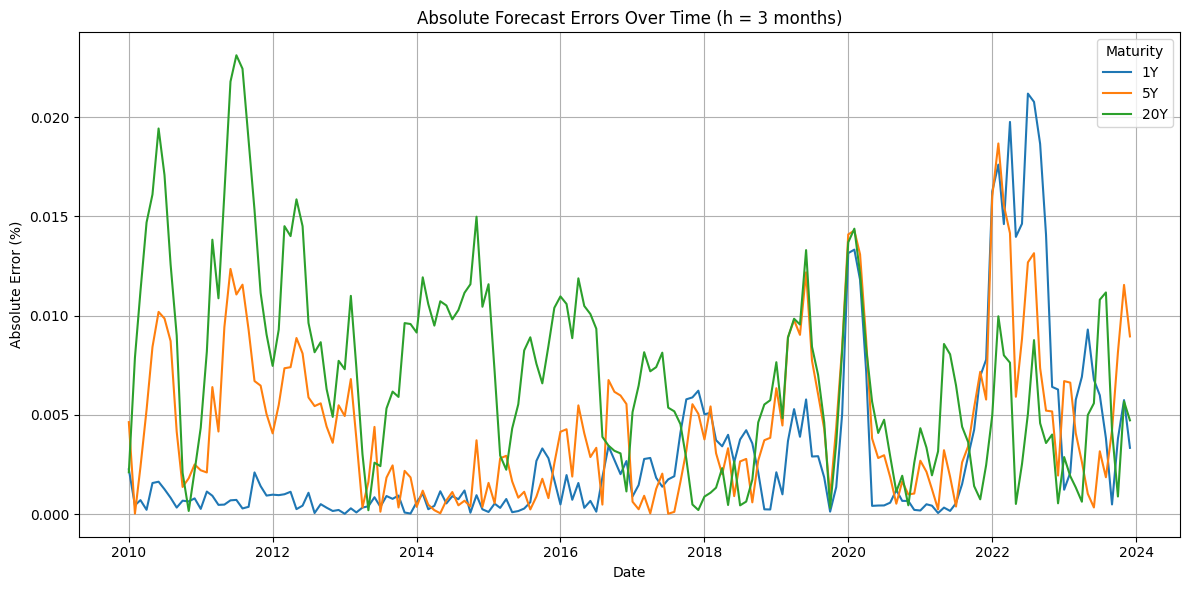

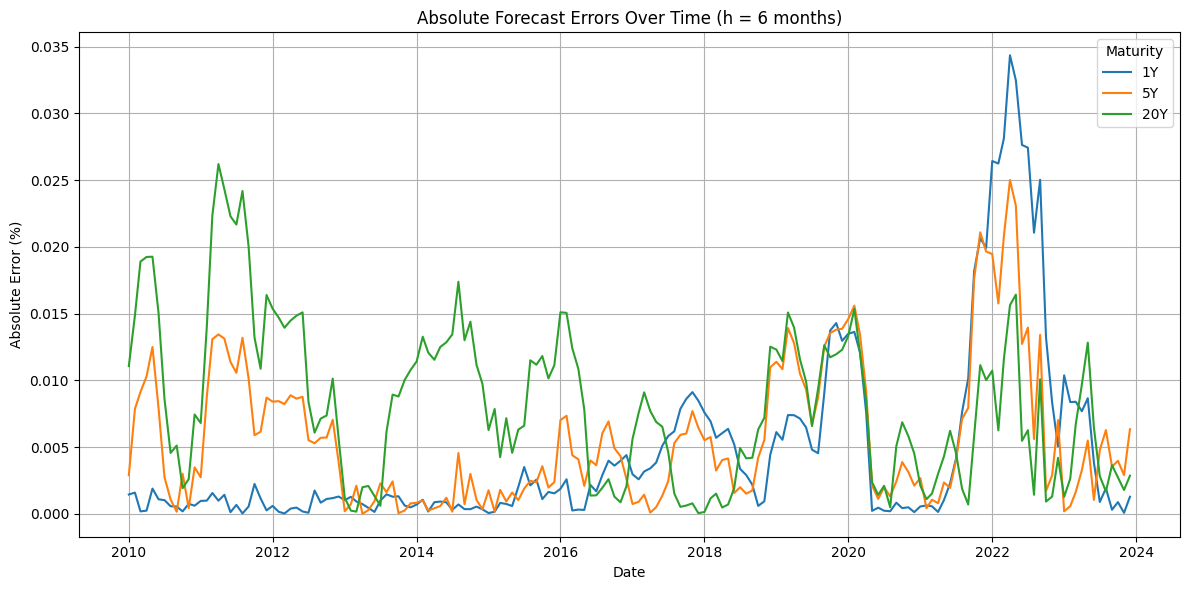

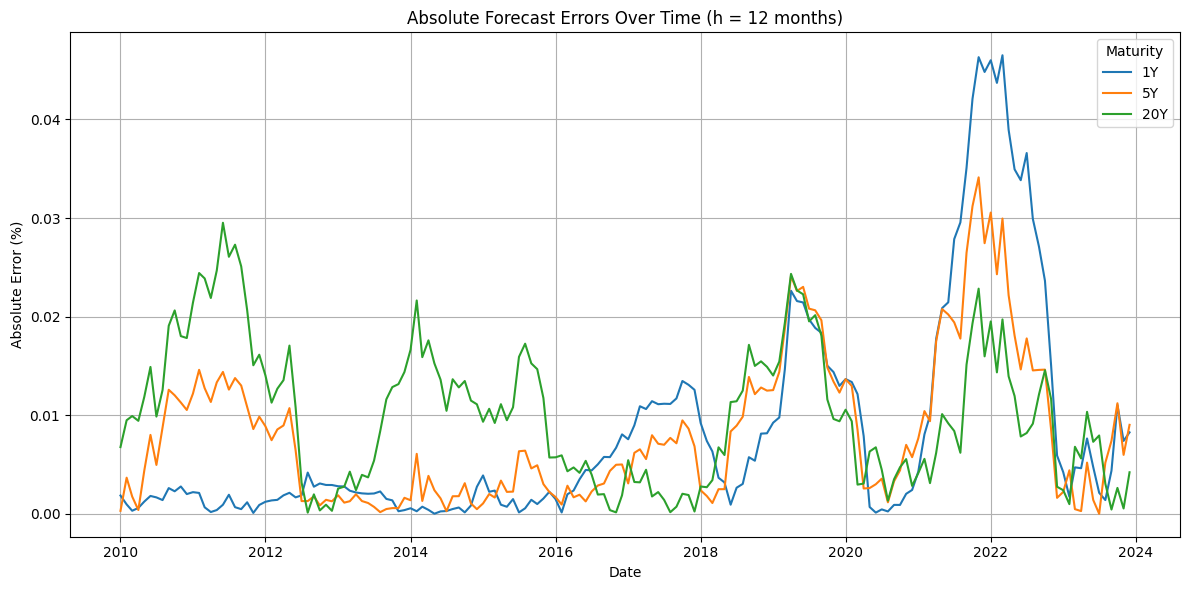

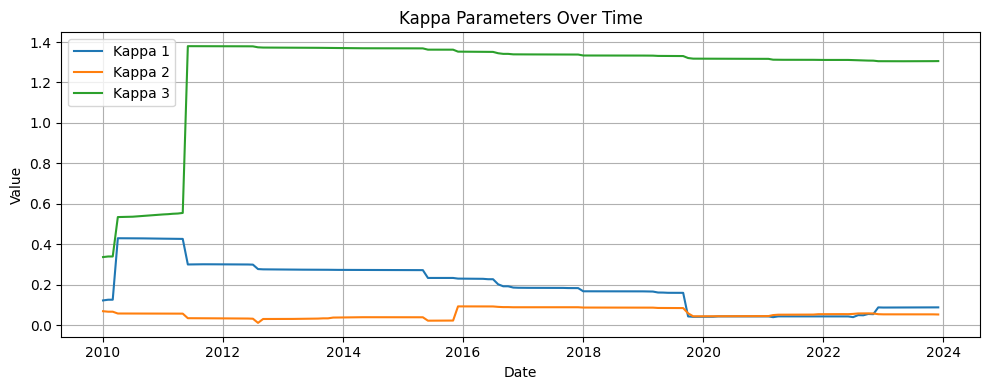

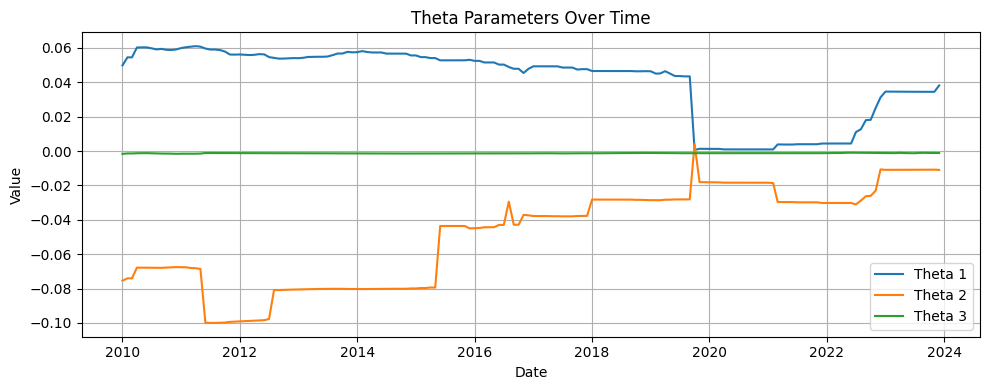

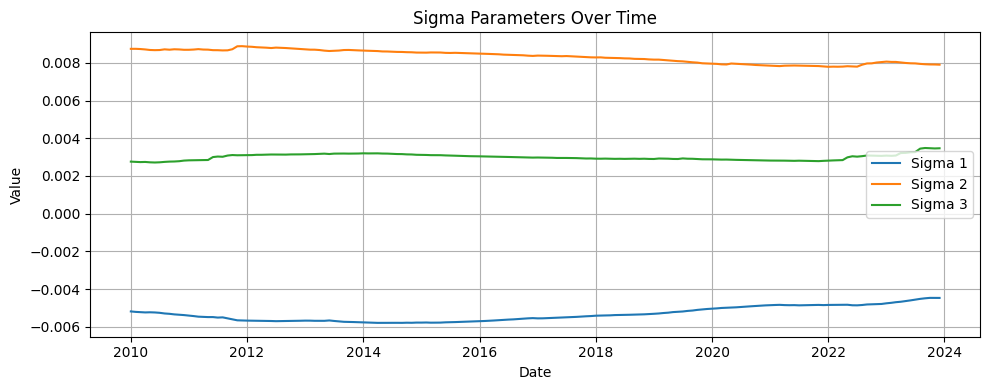

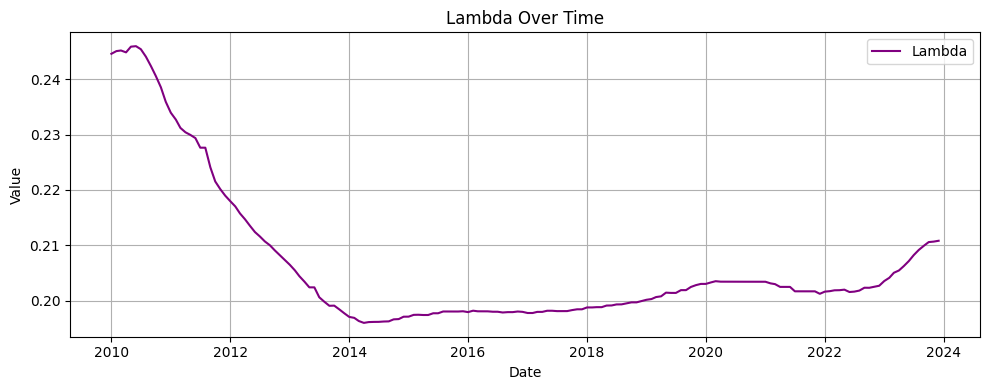

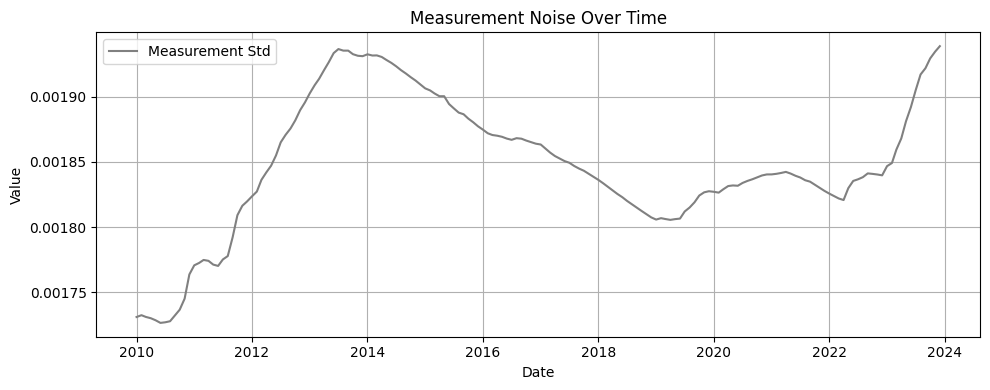

In [ ]:
# Align start date with forecast starting index
aligned_start_date = pd.to_datetime("1995-01-01") + DateOffset(months=start)

# Compute RMSE tables
rmse_tables = compute_rmse_tables_by_maturity(results_all, forecast_maturities_all)

# Plot errors
plot_forecast_errors_by_maturity(results_all, forecast_maturities_all, start_date=aligned_start_date)
plot_afns_parameter_evolution(results_all, start_date=aligned_start_date)